Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License. 

# VISTA-2D Cell Segmentation with Segment Anything Model (SAM) & MONAI

![image](../figures/vista_2d_overview.png)

The tutorial demonstrates how to train a cell segmentation model using the [MONAI](https://monai.io/) framework and the [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) on the [Cellpose dataset](https://www.cellpose.org/).
In Summary the following steps are performed:
- Initialization of the CellSamWrapper model with pre-trained SAM weights
- Creation of data lists for training, validation, and testing
- Definition of data transforms for training and validation
- Setup of datasets and dataloaders with MONAI
- Implementation of the training loop, including:
    - Loss function (CellLoss)
    - Accuracy function (CellAcc)
    - Optimizer (SGD)
- Mixed precision training with GradScaler
- Sliding window inference via MONAI
- Visualization of training loss, validation loss, and validation accuracy
- Inference on a single validation image
- Visualization of input image, ground truth, and model prediction

The notebook demonstrates a complete pipeline for training and evaluating a cell segmentation model using the MONAI framework and the Segment Anything Model (SAM) on the Cellpose dataset. Please note we only use a small subset of the cellpose dataset for this tutorial.

For additional information about VISTA-2D please also refer the [MONAI bundle](https://github.com/Project-MONAI/VISTA/tree/main/vista2d) and the [technical blog post](https://developer.nvidia.com/blog/advancing-cell-segmentation-and-morphology-analysis-with-nvidia-ai-foundation-model-vista-2d/).

For dependency-related issues, you can also check this note:
https://github.com/Project-MONAI/model-zoo/tree/dev/models/vista2d#dependencies.
If you're using MONAI's container, you can disregard the 'opencv-python-headless not installed' error, as it is already included within the container.

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[fire, tifffile, imagecodecs, pillow, tqdm]"
!python -c "import fastremap" || pip install -q fastremap
!python -c "import cellpose" || pip install -q cellpose
!python -c "import natsort" || pip install -q natsort
!python -c "import roifile" || pip install -q roifile
!python -c "import ipykernel" || pip install -q ipykernel
!python -c "import cv2" || pip install -q opencv-python-headless
!python -c "import numba" || pip install -q numba
!python -c "import segment_anything" || pip install -q git+https://github.com/facebookresearch/segment-anything.git
%matplotlib inline

## Setup imports

In [3]:
import json
import os
import time
import shutil
import tempfile

import matplotlib.pyplot as plt
import monai.transforms as mt
import numpy as np
import torch
from monai.apps import download_url
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.inferers import SlidingWindowInfererAdapt
from monai.metrics import CumulativeAverage
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity
from monai.utils import ImageMetaKey
from monai.networks.nets.cell_sam_wrapper import CellSamWrapper
from torch import GradScaler, autocast

from components import CellAcc, CellLoss, LabelsToFlows, LoadTiffd, LogitsToLabels

print_config()

MONAI version: 1.4.0rc6+15.g95211149.dirty
Numpy version: 1.24.4
Pytorch version: 2.5.0a0+872d972e41.nv24.08
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 95211149088489721dffea948ce57b5d44c4cc21
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.20.0a0
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.16.0
pynrrd version: 1.0.0
clearml version: 1.16.4

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Download dataset and Pre-trained weights

The Cellpose dataset needs to be downloaded from [this link](https://www.cellpose.org/).
The SAM weights need to be downloaded [from here](https://github.com/facebookresearch/segment-anything). The exact filename of weights that has been used for this tutorial is `sam_vit_b_01ec64.pth` 

In [5]:
data_list_path = os.path.join(root_dir, "cellpose_toy_datalist.json")
data_list_path_url = "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/cellpose_toy_datalist.json"
download_url(url=data_list_path_url, filepath=data_list_path)

sam_weights_path_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
sam_weights_path = os.path.join(root_dir, "sam_vit_b_01ec64.pth")
download_url(url=sam_weights_path_url, filepath=sam_weights_path)

# TODO: Update this path to the location of the Cellpose dataset on your local machine
data_root = os.path.join(root_dir, "cellpose")

Downloading...
From: https://drive.google.com/uc?id=1dohTDfWO2ruhSqyYMjS0UF5GGGUxrw5N
To: /tmp/tmpe75z17bm/cellpose_toy_datalist.json
100%|██████████| 13.6k/13.6k [00:00<00:00, 1.56MB/s]

2024-09-04 03:13:22,951 - INFO - Downloaded: /workspace/Data/cellpose_toy_datalist.json
2024-09-04 03:13:22,951 - INFO - Expected md5 is None, skip md5 check for file /workspace/Data/cellpose_toy_datalist.json.


## Define the network, load SAM weights

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CellSamWrapper(checkpoint=sam_weights_path)
model.to(device)
print("SAM ViT-B weights loaded succesfully ...")

/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

SAM ViT-B weights loaded succesfully ...


In [4]:
# Create Required Data lists
# Append root path to training, validation and testing data list
with open(data_list_path, "r") as f:
    data = json.load(f)

validation_fold = 0
training_list = []
validation_list = []
testing_list = []

# Process training data
for item in data.get("training", []):
    # Append the base path to image and label
    item["image"] = os.path.join(data_root, item["image"])
    item["label"] = os.path.join(data_root, item["label"])

    if item["fold"] == validation_fold:
        validation_list.append(item)
    else:
        training_list.append(item)

# Process testing data
for item in data.get("testing", []):
    # Append the base path to image and label
    item["image"] = os.path.join(data_root, item["image"])
    item["label"] = os.path.join(data_root, item["label"])
    testing_list.append(item)

print("Appended Data Root to Json file list ...")
print("Total Training Data: {}".format(len(training_list)))
print("Total Validation Data: {}".format(len(validation_list)))
print("Total Testing Data: {}".format(len(testing_list)))

Appended Data Root to Json file list ...
Total Training Data: 40
Total Validation Data: 10
Total Testing Data: 68


## Training & Validation Transforms

In [ ]:
roi_size = [256, 256]
train_transforms = mt.Compose(
    [
        LoadTiffd(keys=["image", "label"]),
        mt.EnsureTyped(keys=["image", "label"], data_type="tensor", dtype=torch.float),
        mt.ScaleIntensityd(keys="image", minv=0, maxv=1, channel_wise=True),
        mt.ScaleIntensityRangePercentilesd(
            keys="image",
            lower=1,
            upper=99,
            b_min=0.0,
            b_max=1.0,
            channel_wise=True,
            clip=True,
        ),
        mt.SpatialPadd(keys=["image", "label"], spatial_size=roi_size),
        mt.RandSpatialCropd(keys=["image", "label"], roi_size=roi_size),
        mt.RandAffined(
            keys=["image", "label"],
            prob=0.5,
            rotate_range=np.pi,
            scale_range=[-0.5, 0.5],
            mode=["bilinear", "nearest"],
            spatial_size=roi_size,
            cache_grid=True,
            padding_mode="border",
        ),
        mt.RandAxisFlipd(keys=["image", "label"], prob=0.5),
        mt.RandGaussianNoised(keys=["image"], prob=0.25, mean=0, std=0.1),
        mt.RandAdjustContrastd(keys=["image"], prob=0.25, gamma=(1, 2)),
        mt.RandGaussianSmoothd(keys=["image"], prob=0.25, sigma_x=(1, 2)),
        mt.RandHistogramShiftd(keys=["image"], prob=0.25, num_control_points=3),
        mt.RandGaussianSharpend(keys=["image"], prob=0.25),
        LabelsToFlows(keys="label", flow_key="flow"),
    ]
)

val_transforms = mt.Compose(
    [
        LoadTiffd(keys=["image", "label"], allow_missing_keys=True),
        mt.EnsureTyped(
            keys=["image", "label"],
            data_type="tensor",
            dtype=torch.float,
            allow_missing_keys=True,
        ),
        mt.ScaleIntensityRangePercentilesd(
            keys="image",
            lower=1,
            upper=99,
            b_min=0.0,
            b_max=1.0,
            channel_wise=True,
            clip=True,
        ),
        LabelsToFlows(keys="label", flow_key="flow", allow_missing_keys=True),
    ]
)

# Datasets & Dataloaders for training, validation and testing
train_dataset = Dataset(data=training_list, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)

val_dataset = Dataset(data=validation_list, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

# Training loop with validation
loss_function = CellLoss()
acc_function = CellAcc()

# Define the Sliding Window Inferer
sliding_inferrer = SlidingWindowInfererAdapt(
    roi_size=[256, 256], sw_batch_size=1, overlap=0.25, cache_roi_weight_map=True, progress=False
)

channels_last = True

ckpt_path = os.path.join(data_root, "model_checkpoints")
if os.path.exists(ckpt_path) is False:
    os.mkdir(ckpt_path)
# To increase performance, more data would be needed,
# epochs can be increased for better results.
# Over-fitting is possible, hence please be careful with the number of epochs
# Differnet optimizers can be used as well for varying results.
# Please refer to VISTA-2D MONAI Bundle for more information.
max_epochs = 10

num_epochs_per_validation = 2

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-5)

# Amp
scaler = GradScaler("cuda")
amp_dtype = torch.float16

best_ckpt_path = os.path.join(ckpt_path, "model.pt")
intermediate_ckpt_path = os.path.join(ckpt_path, "model_final.pt")

best_metric = -1
start_epoch = 0
best_metric_epoch = -1
epoch_loss_values = []
val_epoch_loss_values = []
val_epoch_acc_values = []
for epoch in range(0, max_epochs):
    start_time = time.time()
    train_loss, train_acc = 0, 0

    model.train()
    memory_format = torch.channels_last if channels_last else torch.preserve_format
    run_loss = CumulativeAverage()
    avg_loss = avg_acc = 0

    for idx, batch_data in enumerate(train_loader):
        data = batch_data["image"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

        target = batch_data["flow"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

        optimizer.zero_grad(set_to_none=True)

        # Use autocast with float16 for mixed precision training
        with autocast("cuda", dtype=amp_dtype):
            logits = model(data)
            loss = loss_function(logits.float(), target)

        # Use the scaler for backpropagation and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_size = data.shape[0]
        run_loss.append(loss, count=batch_size)
        avg_loss = run_loss.aggregate()

        print(f"Epoch {epoch}/{max_epochs} {idx}/{len(train_loader)} ")
        print(f"loss: {avg_loss:.4f} time {time.time() - start_time:.2f}s ")

    optimizer.zero_grad()

    epoch_loss_values.append(avg_loss)

    # Validation loop & model checkpoints
    if epoch % num_epochs_per_validation == 0:
        optimizer.zero_grad(set_to_none=True)
        model = model.to(device)
        model.eval()

        with torch.no_grad():
            val_run_loss = CumulativeAverage()
            run_acc = CumulativeAverage()
            for val_idx, val_batch in enumerate(val_loader):
                v_data = val_batch["image"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

                target = val_batch["flow"].as_subclass(torch.Tensor).to(device=device)

                filename = val_batch["image"].meta[ImageMetaKey.FILENAME_OR_OBJ]
                batch_size = v_data.shape[0]
                loss = acc = None
                # Use autocast with float16 for mixed precision validation
                with autocast("cuda", dtype=amp_dtype):
                    logits = sliding_inferrer(inputs=v_data, network=model)
                    val_loss = loss_function(logits, target)

                val_run_loss.append(val_loss.to(device=device), count=batch_size)
                target = None

                pred_mask_all = []

                for b_ind in range(logits.shape[0]):  # go over batch dim
                    pred_mask, p = LogitsToLabels()(logits=logits[b_ind], filename=filename)
                    pred_mask_all.append(pred_mask)

                if acc_function is not None:
                    label = val_batch["label"].as_subclass(torch.Tensor)

                    for b_ind in range(label.shape[0]):
                        acc = acc_function(pred_mask_all[b_ind], label[b_ind, 0].long())
                        acc = acc.detach().clone() if isinstance(acc, torch.Tensor) else torch.tensor(acc)

                        run_acc.append(acc.to(device=device), count=1)
                    label = None

                avg_loss = val_loss.cpu() if val_loss is not None else 0
                avg_acc = acc.cpu().numpy() if acc is not None else 0

                print(f"Val {epoch}/{max_epochs} {val_idx}/{len(val_loader)} ")
                print(f"loss: {avg_loss:.4f} acc {avg_acc}  time {time.time() - start_time:.2f}s")

        val_epoch_loss_values.append(val_run_loss.aggregate())
        val_epoch_acc_values.append(run_acc.aggregate())
    # Model Saving & Checkpointing
    if avg_loss < best_metric:
        best_metric = avg_loss
        state_dict = model.state_dict()
        torch.save({"state_dict": state_dict}, best_ckpt_path)
        print(f"Model saved to {best_ckpt_path}")
print("Training Complete!")

## Loss plot visualization 

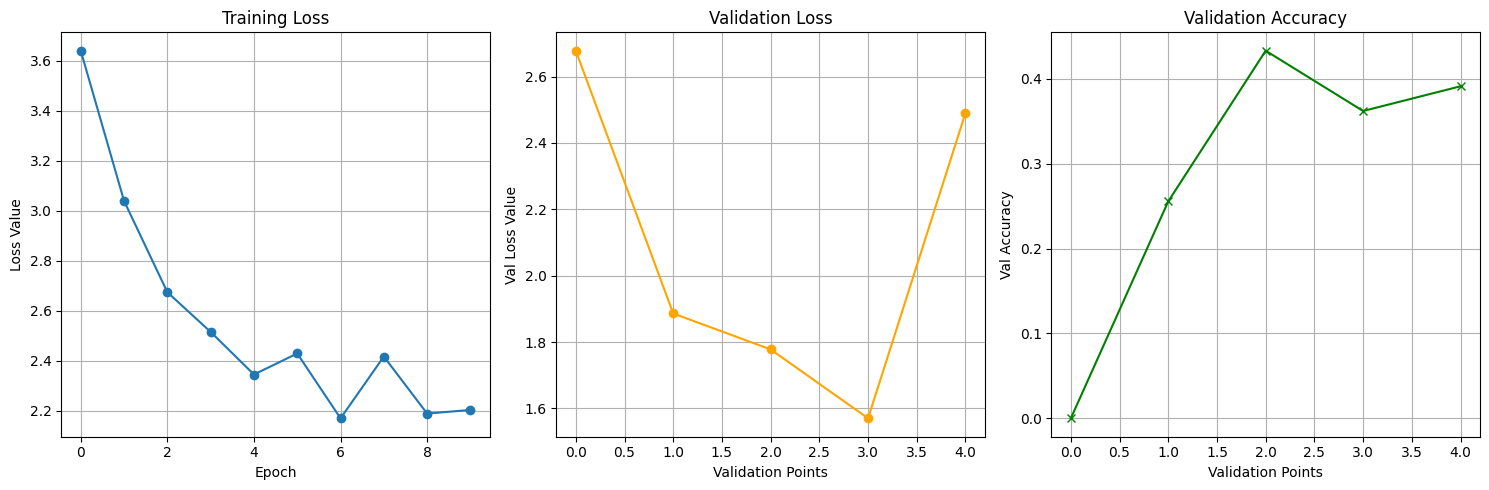

In [6]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Loss
axs[0].plot(range(0, max_epochs), epoch_loss_values, marker="o")
axs[0].set_title("Training Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss Value")
axs[0].grid(True)

# Plot 2: Validation Loss
axs[1].plot(val_epoch_loss_values, marker="o", color="orange")
axs[1].set_title("Validation Loss")
axs[1].set_xlabel("Validation Points")
axs[1].set_ylabel("Val Loss Value")
axs[1].grid(True)

# Plot 3: Validation Accuracy
axs[2].plot(val_epoch_acc_values, marker="x", color="green")
axs[2].set_title("Validation Accuracy")
axs[2].set_xlabel("Validation Points")
axs[2].set_ylabel("Val Accuracy")
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Define a transform to load and preprocess the image and visualize the results


(3, 512, 478)
(512, 478)
(512, 478)


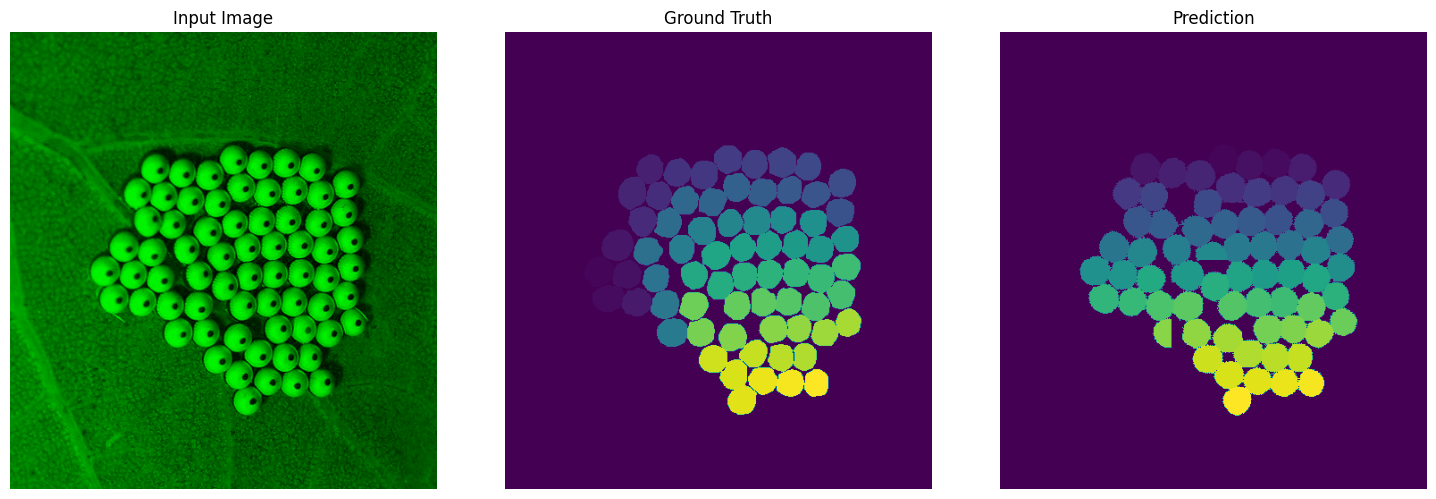

Image shape: (512, 478, 3)
Label shape: (512, 478)
Prediction shape: (512, 478)
Unique values in label: [0.         0.01470588 0.02941176 0.04411765 0.05882353 0.07352941
 0.0882353  0.10294118 0.11764706 0.13235295 0.14705883 0.16176471
 0.1764706  0.19117647 0.20588236 0.22058824 0.23529412 0.25
 0.2647059  0.27941176 0.29411766 0.30882353 0.32352942 0.3382353
 0.3529412  0.36764705 0.38235295 0.3970588  0.4117647  0.42647058
 0.44117647 0.45588234 0.47058824 0.4852941  0.5        0.5147059
 0.5294118  0.5441176  0.5588235  0.5735294  0.5882353  0.60294116
 0.61764705 0.63235295 0.64705884 0.6617647  0.6764706  0.6911765
 0.7058824  0.7205882  0.7352941  0.75       0.7647059  0.7794118
 0.7941176  0.8088235  0.8235294  0.8382353  0.85294116 0.86764705
 0.88235295 0.89705884 0.9117647  0.9264706  0.9411765  0.9558824
 0.9705882  0.9852941  1.        ]
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34

In [7]:
preprocess = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

# Load a single validation image (index 2)
val_item = validation_list[2]
image_path = val_item["image"]
label_path = val_item["label"]

# Load and preprocess the image and label
image = preprocess(image_path)
label = preprocess(label_path)

# Ensure model is in eval mode and on the correct device
model.eval()
model.to(device)

# Perform inference
with torch.no_grad():
    input_tensor = torch.as_tensor(image).unsqueeze(0).to(device)
    with autocast("cuda", dtype=amp_dtype):
        logits = sliding_inferrer(inputs=input_tensor, network=model)

# Convert logits to prediction mask
pred_mask, _ = LogitsToLabels()(logits=logits[0])

# Move tensors to CPU and convert to numpy for visualization
image = image.squeeze().cpu().numpy()
label = label.squeeze().cpu().numpy()

print(image.shape)
print(label.shape)
print(pred_mask.shape)
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Handle potential multi-channel images
if image.ndim == 3 and image.shape[0] in [1, 3, 4]:
    image = np.transpose(image, (1, 2, 0))
    if image.shape[2] == 1:
        image = image[:, :, 0]

axes[0].imshow(image, cmap="gray" if image.ndim == 2 else None)
axes[0].set_title("Input Image")
axes[0].axis("off")

if label.ndim == 3 and label.shape[0] == 1:
    label = label[0]
axes[1].imshow(label, cmap="viridis")
axes[1].set_title("Ground Truth")
axes[1].axis("off")

if pred_mask.ndim == 3 and pred_mask.shape[0] == 1:
    pred_mask = pred_mask[0]
axes[2].imshow(pred_mask, cmap="viridis")
axes[2].set_title("Prediction")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")
print(f"Prediction shape: {pred_mask.shape}")
print(f"Unique values in label: {np.unique(label)}")
print(f"Unique values in prediction: {np.unique(pred_mask)}")

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)